<h4>ChatGPT Internal Source Consistency Analysis</h4>
<p>
This notebook evaluates ChatGPT’s internal consistency in source citation behavior. Each query was executed three independent times using the ChatGPT web interface. Each query thus contributes three independent source lists.
</p>

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "src")))
from data import get_chatgpt_df
from metrics import syntactic_overlap
from plots import boxplot, heatmaps

<h4>Dataset: ChatGPT</h4>

In [2]:
chatgpt_df = get_chatgpt_df()
chatgpt_df

,query,product,market_type,query_level,response_text,sources_cited,sources_additional,sources_all,domains_cited,domains_additional,domains_all,recommended_products
0,What is the best smartphone?,Smartphone,Commodity / Saturated,General,[There’s no one “best” smartphone that’s perfe...,[[https://www.tomsguide.com/best-picks/best-ph...,[[https://www.tomsguide.com/phones/android-pho...,[[https://www.tomsguide.com/best-picks/best-ph...,"[[tomsguide.com, forbes.com], [tomsguide.com],...","[[reddit.com, tomsguide.com, techrepublic.com,...","[[tomsguide.com, forbes.com, reddit.com, techr...","[[Apple iPhone 17 Pro Max, Samsung Galaxy S25 ..."
1,What is the best smartphone under 1000 dollars?,Smartphone,Commodity / Saturated,General & Price,"[There’s no one “best” smartphone under $1,000...",[[https://www.tomsguide.com/best-picks/best-ph...,[[https://www.androidcentral.com/best-android-...,[[https://www.tomsguide.com/best-picks/best-ph...,"[[tomsguide.com, phonearena.com, wired.com], [...","[[reddit.com, theverge.com, techadvisor.com, w...","[[tomsguide.com, phonearena.com, wired.com, re...","[[Samsung Galaxy S25, Samsung Galaxy S25+, App..."
2,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature,"[There’s no one-size-fits-all “best” phone, be...",[[https://www.techradar.com/news/best-cameraph...,[[https://coffeechoice.org/en/best-smartphones...,[[https://www.techradar.com/news/best-cameraph...,"[[tomsguide.com, techradar.com], [abdgadgets.c...","[[reddit.com, tomsguide.com, stuff.tv, techadv...","[[tomsguide.com, techradar.com, reddit.com, st...","[[Apple iPhone 16 Pro, Samsung Galaxy S25 Ultr..."
3,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature & Feature,[That’s a great question — the “best” depends ...,[[https://www.androidcentral.com/phones/oneplu...,[[https://www.techadvisor.com/article/723383/b...,[[https://www.androidcentral.com/phones/oneplu...,"[[androidcentral.com, tomsguide.com, phonearen...","[[tomsguide.com, wired.com, co.uk, 9to5google....","[[androidcentral.com, tomsguide.com, phonearen...","[[OnePlus 13, Samsung Galaxy S25, Google Pixel..."
4,What is the best laptop?,Laptop,Commodity / Saturated,General,[There’s no one-size-fits-all “best laptop” — ...,[[https://www.pcworld.com/article/436674/best-...,[[https://www.bleepingcomputer.com/forums/t/81...,[[https://www.pcworld.com/article/436674/best-...,"[[windowscentral.com, rtings.com, pcworld.com,...","[[reddit.com, bestbuy.com, windowscentral.com,...","[[windowscentral.com, rtings.com, pcworld.com,...","[[Lenovo Yoga 9i 2-in-1 Aura Edition, Lenovo T..."
5,What is the best laptop under 1500 dollars?,Laptop,Commodity / Saturated,General & Price,[There’s no one-size-fits-all “best” laptop un...,[[https://www.tomshardware.com/best-picks/best...,[[https://www.laptopmag.com/articles/best-lapt...,[[https://www.tomshardware.com/best-picks/best...,"[[tomshardware.com, wired.com], [tomshardware....","[[reddit.com, tomshardware.com, pcworld.com, y...","[[tomshardware.com, wired.com, reddit.com, pcw...","[[HP Victus 16, Asus Zenbook S 16, MacBook Air..."
6,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature,[“Best” depends a lot on what you plan to use ...,[[https://www.tomshardware.com/best-picks/best...,[[https://www.laptopmag.com/articles/best-lapt...,[[https://www.tomshardware.com/best-picks/best...,"[[tomshardware.com, techradar.com], [tomshardw...","[[reddit.com, tomsguide.com, tomshardware.com,...","[[tomshardware.com, techradar.com, reddit.com,...","[[HP Victus 16, Apple MacBook Air 15″ (M4), HP..."
7,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature & Feature,[“Best” always depends a bit on what you value...,[[https://www.ultrabookreview.com/2071-best-ga...,[[https://www.pcworld.com/article/436674/best-...,[[https://www.ultrabookreview.com/2071-best-

<h4>Mean Internal Source Overlap - Definition & Implementation</h4> 
<p>To evaluate how consistent ChatGPT is in the sources it cites across multiple runs of the same query, we define the Mean Internal Source Overlap (MISO). This metric captures, on average, how much the sets of retrieved or cited sources overlap syntactically between runs, providing a way to measure the stability of ChatGPT’s information retrieval process.</p>

<p>
Formally, let \( C = \{(i, j) \mid 1 \le i < j \le |S_{GPT_q}|\} \) denote the set of all unique pairs of source lists for query \( q \), such that \( |C| = \binom{|S_{GPT_q}|}{2} \). 
Then, the Mean Internal Source Overlap is defined as:
</p> 

<p style="text-align:center;"> 
\( MISO(q) = \frac{1}{|C|} \sum_{(i, j) \in C} O_{\text{syntactic}}(s_{qi}, s_{qj}) \) 
</p> 

<p>
where \( O_{\text{syntactic}}(s_{qi}, s_{qj}) \) represents the syntactic overlap between the two source lists \( s_{qi} \) and \( s_{qj} \). This coefficient captures the proportion of shared sources relative to the smaller of the two lists, making it robust to list length differences. Higher MISO values indicate greater internal consistency in ChatGPT’s source selection, reflecting stable retrieval behavior across independent runs of the same query.
</p>

In [3]:
def calc_miso(chatgpt_df, chatgpt_sources, overlap_function):
    from itertools import combinations
    
    mipo_results = []

    for _, row in chatgpt_df.iterrows():
        row_list = row[chatgpt_sources]
        pairwise_scores = []

        for c in combinations(row_list, 2):
            score = overlap_function(c[0], c[1])
            pairwise_scores.append(score)

        syntactic_mean = np.mean(pairwise_scores)
        syntactic_var = np.var(pairwise_scores, ddof = 0)
        syntactic_std = np.sqrt(syntactic_var)

        mipo_results.append({
            "query": row["query"],
            "product": row["product"],
            "market_type": row["market_type"],
            "query_level": row["query_level"],
            "miso_mean": syntactic_mean,
            "miso_var": syntactic_var,
            "miso_std": syntactic_std
        })

    return pd.DataFrame(mipo_results)

<h4>Mean Internal Source Overlap - Cited Sources Analysis</h4>

In [4]:
miso_df_cs = calc_miso(chatgpt_df, chatgpt_sources = "sources_cited", overlap_function = syntactic_overlap)
miso_df_cs

,query,product,market_type,query_level,miso_mean,miso_var,miso_std
0,What is the best smartphone?,Smartphone,Commodity / Saturated,General,1.000000,0.000000,0.000000
1,What is the best smartphone under 1000 dollars?,Smartphone,Commodity / Saturated,General & Price,0.250000,0.125000,0.353553
2,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature,0.333333,0.222222,0.471405
3,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature & Feature,0.000000,0.000000,0.000000
4,What is the best laptop?,Laptop,Commodity / Saturated,General,0.666667,0.000000,0.000000
5,What is the best laptop under 1500 dollars?,Laptop,Commodity / Saturated,General & Price,0.500000,0.000000,0.000000
6,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature,0.833333,0.055556,0.235702
7,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature & Feature,0.166667,0.055556,0.235702
8,What is the best smartwatch?,Smartwatch,Commodity / Saturated,General,0.666667,0.013889,0.117851
9,What is the best smartwatch under 800 dollars?,Smartwatch,Commodity / Saturated,General & Price,1.000000,0.000000,0.000000


<h4>Mean Internal Source Overlap - Analysis (Cited Sources)</h4>

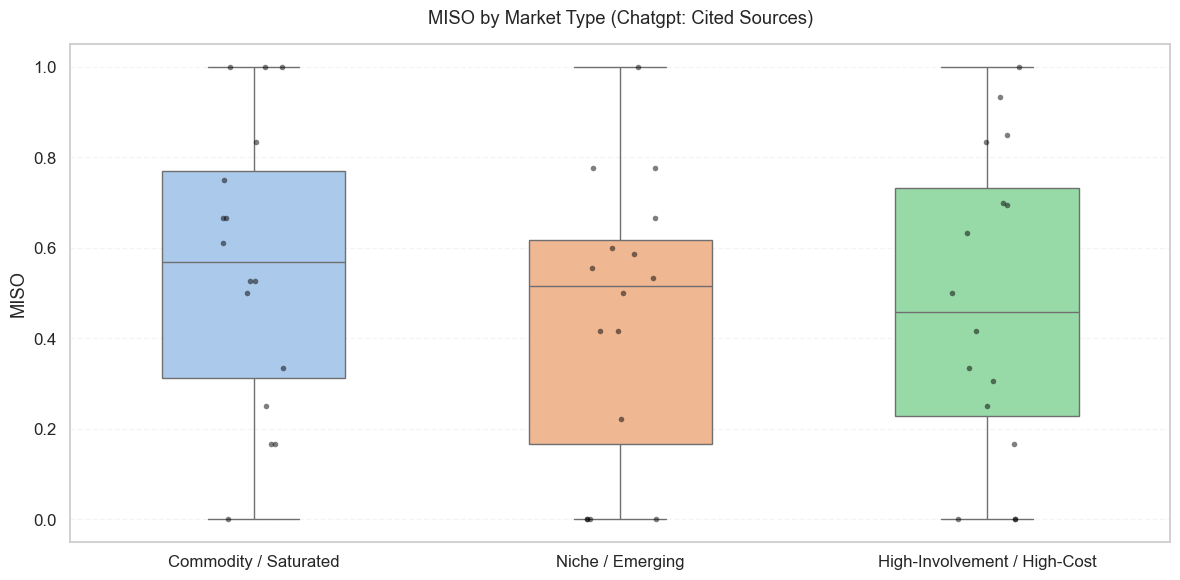

In [5]:
miso_cs_cs = miso_df_cs[miso_df_cs["market_type"] == "Commodity / Saturated"]
miso_ne_cs = miso_df_cs[miso_df_cs["market_type"] == "Niche / Emerging"]
miso_hh_cs = miso_df_cs[miso_df_cs["market_type"] == "High-Involvement / High-Cost"]

plot_df_cs = pd.DataFrame({
    "MISO": pd.concat([
        miso_cs_cs["miso_mean"],
        miso_ne_cs["miso_mean"],
        miso_hh_cs["miso_mean"],
    ], ignore_index = True),
    "Market Type": (
        ["Commodity / Saturated"] * len(miso_cs_cs)
        + ["Niche / Emerging"] * len(miso_ne_cs)
        + ["High-Involvement / High-Cost"] * len(miso_hh_cs)
    )
})

boxplot(
    df = plot_df_cs,
    x_col = "Market Type",
    y_col = "MISO",
    order = ["Commodity / Saturated", "Niche / Emerging", "High-Involvement / High-Cost"],
    title = "MISO by Market Type (Chatgpt: Cited Sources)",
    xlabel = "",
    ylabel = "MISO"
)

<h4>MISO by Market Type (ChatGPT: Cited Sources)</h4> 

<p>This boxplot compares the distribution of Mean Internal Source Overlap (MISO) for Commodity/Saturated, Niche/Emerging, and High-Involvement/High-Cost markets. Commodity queries show a higher central tendency than High-Involvement, with Niche in between. All three include runs with very high overlap as well as low-overlap cases.</p> 

<ul> 
    <li>Commodity markets often reuse authoritative, well-indexed sources. Strong intent match and domain authority keep citations stable.</li> 
    <li>Niche markets mix specialized blogs and docs. Authority is fragmented, so overlap varies with freshness and vertical intent.</li> 
    <li>High-Involvement queries invite broader comparison content. SERP competition and diversity push the model to sample more sources, lowering overlap.</li> 
</ul> 
    
<p>Overall, internal consistency is strongest where authority signals are concentrated and weakest where diversity and specification pressure the retrieval layer.</p>

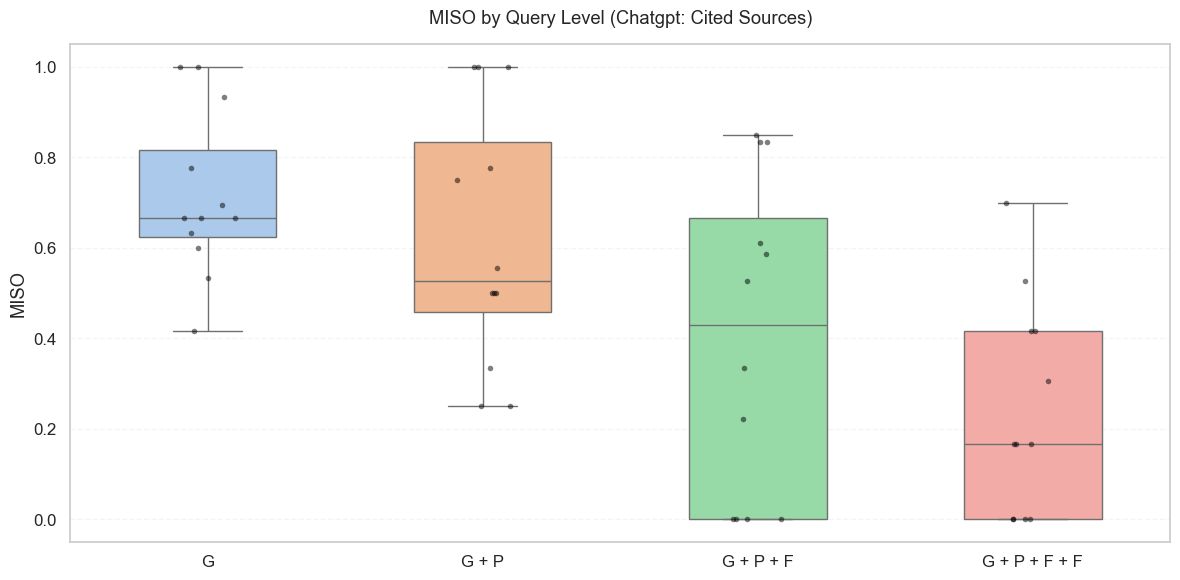

In [6]:
miso_g_cs = miso_df_cs[miso_df_cs["query_level"] == "General"]
miso_gp_cs = miso_df_cs[miso_df_cs["query_level"] == "General & Price"]
miso_gpf_cs = miso_df_cs[miso_df_cs["query_level"] == "General & Price & Feature"]
miso_gpff_cs = miso_df_cs[miso_df_cs["query_level"] == "General & Price & Feature & Feature"]

plot_df_cs = pd.DataFrame({
    "MISO": pd.concat([
        miso_g_cs["miso_mean"],
        miso_gp_cs["miso_mean"],
        miso_gpf_cs["miso_mean"],
        miso_gpff_cs["miso_mean"]
    ], ignore_index = True),
    "Query Level": (
        ["G"] * len(miso_g_cs)
        + ["G + P"] * len(miso_gp_cs)
        + ["G + P + F"] * len(miso_gpf_cs)
        + ["G + P + F + F"] * len(miso_gpff_cs)
    )
})

boxplot(
    df = plot_df_cs,
    x_col = "Query Level",
    y_col = "MISO",
    order = ["G", "G + P", "G + P + F", "G + P + F + F"],
    title = "MISO by Query Level (Chatgpt: Cited Sources)",
    xlabel = "",
    ylabel = "MISO"
)

<h4>MISO by Query Level (ChatGPT: Cited Sources)</h4> 

<p>This boxplot shows a steady decline in MISO as queries add constraints from general (G) to price and feature filters (G+P+F+F). General queries cluster at higher overlap, while more specific queries shift toward lower overlap, with greater dispersion.</p> 

<ul> 
    <li>Added constraints narrow candidate sets and shift intent focus, so different valid sources satisfy each run, reducing overlap.</li> 
    <li>At G, broad consensus and high-authority domains dominate, producing stable citation patterns.</li> 
    <li>At G+P(+F), factors like freshness, product variation, and retail verticals expand possible matches, increasing citation rotation.</li>
    <li>LLM retrieval and citation processes amplify these effects through constraint satisfaction and sensitivity to small content or link differences.</li> 
</ul> 

<p>Overall, MISO declines with query complexity, indicating that ChatGPT’s citation consistency weakens as specificity and diversity pressures increase.</p>

<br />

<h4>Mean Internal Source Overlap - Analyis (All Sources)</h4>

In [7]:
miso_df_as = calc_miso(chatgpt_df, chatgpt_sources = "sources_all", overlap_function = syntactic_overlap)
miso_df_as

,query,product,market_type,query_level,miso_mean,miso_var,miso_std
0,What is the best smartphone?,Smartphone,Commodity / Saturated,General,0.933333,0.002222,0.047140
1,What is the best smartphone under 1000 dollars?,Smartphone,Commodity / Saturated,General & Price,0.788235,0.012129,0.110130
2,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature,0.827778,0.003025,0.054997
3,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature & Feature,0.733333,0.035556,0.188562
4,What is the best laptop?,Laptop,Commodity / Saturated,General,0.848485,0.001837,0.042855
5,What is the best laptop under 1500 dollars?,Laptop,Commodity / Saturated,General & Price,0.358586,0.040455,0.201134
6,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature,0.941919,0.001696,0.041186
7,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature & Feature,0.361111,0.145247,0.381113
8,What is the best smartwatch?,Smartwatch,Commodity / Saturated,General,0.866667,0.035556,0.188562
9,What is the best smartwatch under 800 dollars?,Smartwatch,Commodity / Saturated,General & Price,0.777778,0.024691,0.157135


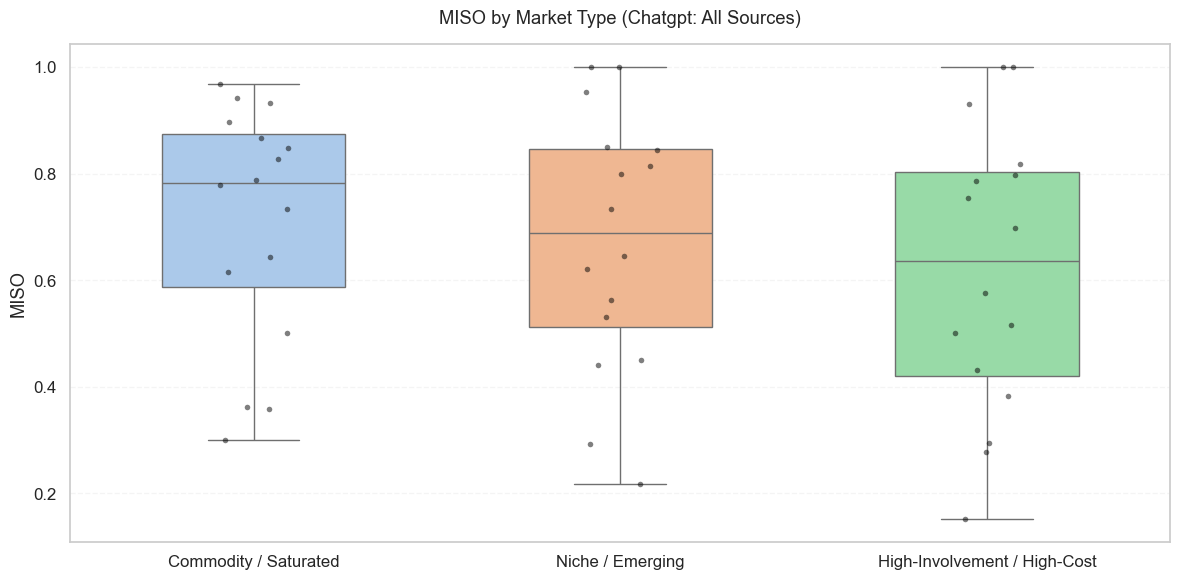

In [8]:
miso_cs_as = miso_df_as[miso_df_as["market_type"] == "Commodity / Saturated"]
miso_ne_as = miso_df_as[miso_df_as["market_type"] == "Niche / Emerging"]
miso_hh_as = miso_df_as[miso_df_as["market_type"] == "High-Involvement / High-Cost"]

plot_df_as = pd.DataFrame({
    "MISO": pd.concat([
        miso_cs_as["miso_mean"],
        miso_ne_as["miso_mean"],
        miso_hh_as["miso_mean"],
    ], ignore_index = True),
    "Market Type": (
        ["Commodity / Saturated"] * len(miso_cs_as)
        + ["Niche / Emerging"] * len(miso_ne_as)
        + ["High-Involvement / High-Cost"] * len(miso_hh_as)
    )
})

boxplot(
    df = plot_df_as,
    x_col = "Market Type",
    y_col = "MISO",
    order = ["Commodity / Saturated", "Niche / Emerging", "High-Involvement / High-Cost"],
    title = "MISO by Market Type (Chatgpt: All Sources)",
    xlabel = "",
    ylabel = "MISO"
)

<h4>MISO by Market Type (ChatGPT: All Sources)</h4> 

<p>This boxplot shows the Mean Internal Source Overlap (MISO) across all sources for each market type. Commodity queries have the highest median overlap, followed by Niche, with High-Involvement markets showing the lowest consistency.</p> 

<ul> 
    <li>Commodity markets rely on concentrated, high-authority domains that frequently co-occur across responses, leading to stronger overlap.</li>
    <li>Niche markets depend on specialized but fragmented information, balancing between stable core sources and rotating supplemental ones.</li>
    <li>High-Involvement topics draw from diverse retail, review, and manufacturer content; varied SERP verticals reduce repetition across runs.</li>
    <li>Inclusion of uncited sources expands the retrieval set, highlighting how background sourcing reflects SERP breadth and authority concentration by market.</li> 
</ul> 

<p>Overall, MISO patterns confirm that ChatGPT’s underlying retrieval stability mirrors real-world market concentration (more stable in saturated domains, less so in high-cost or fragmented markets).</p>

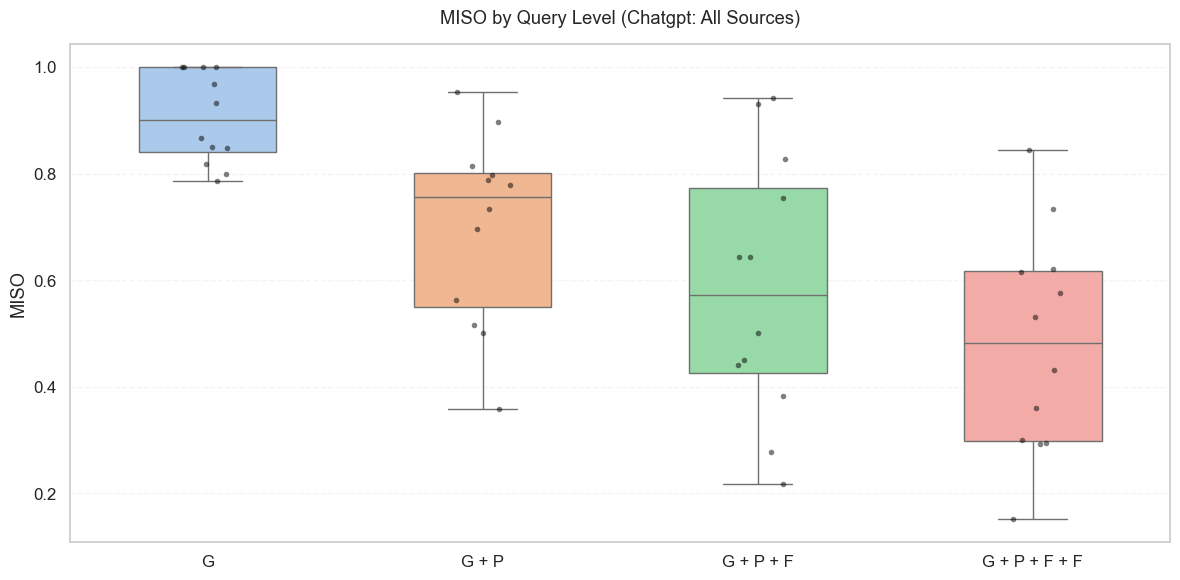

In [9]:
miso_g_as = miso_df_as[miso_df_as["query_level"] == "General"]
miso_gp_as = miso_df_as[miso_df_as["query_level"] == "General & Price"]
miso_gpf_as = miso_df_as[miso_df_as["query_level"] == "General & Price & Feature"]
miso_gpff_as = miso_df_as[miso_df_as["query_level"] == "General & Price & Feature & Feature"]

plot_df_as = pd.DataFrame({
    "MISO": pd.concat([
        miso_g_as["miso_mean"],
        miso_gp_as["miso_mean"],
        miso_gpf_as["miso_mean"],
        miso_gpff_as["miso_mean"]
    ], ignore_index = True),
    "Query Level": (
        ["G"] * len(miso_g_as)
        + ["G + P"] * len(miso_gp_as)
        + ["G + P + F"] * len(miso_gpf_as)
        + ["G + P + F + F"] * len(miso_gpff_as)
    )
})

boxplot(
    df = plot_df_as,
    x_col = "Query Level",
    y_col = "MISO",
    order = ["G", "G + P", "G + P + F", "G + P + F + F"],
    title = "MISO by Query Level (Chatgpt: All Sources)",
    xlabel = "",
    ylabel = "MISO"
)

<h4>MISO by Query Level (ChatGPT: All Sources)</h4> 

<p>This boxplot compares MISO across query levels from general (G) to feature- and filter-rich (G+P+F+F). Overlap declines progressively, indicating less source consistency as queries become more specific.</p> 

<ul> 
    <li>General queries retrieve stable, high-authority pages with broad topical coverage, yielding high overlap.</li> 
    <li>As price and feature constraints are added, candidate sets narrow and diversify across product variants and verticals, reducing consistency.</li> 
    <li>Broader retrieval (including uncited sources) captures background shifts in SERP composition as intent becomes more granular.</li> 
    <li>ChatGPT’s extraction sensitivity and balancing of relevance vs. diversity further lower overlap for complex, constraint-heavy prompts.</li> </ul> 
    
<p>Overall, MISO decreases with query complexity, showing that ChatGPT’s total retrieval footprint becomes less stable as specificity, filtering, and market heterogeneity increase.</p>

<br />

<h4>Cross-Query Mean Internal Source Overlap (Allpairs) – Definition &amp; Implementation</h4> 

<p>To move beyond consistency within a single query, we extend the analysis across queries by defining the Cross-Query Mean Internal Source Overlap (CQMISO). This metric measures the overlap of ChatGPT’s <em>sources</em> between different queries, capturing patterns of overlap in the model’s sourcing behavior across topics.</p> 

<p> Formally, for each query \( q \), let the set of source lists generated by ChatGPT be \( S_{GPT_q} = [s_{q1}, s_{q2}, s_{q3}] \). To measure overlap between two distinct queries \( i \) and \( j \), we define: </p> 

<p> $$ CQMISO[i, j] = \frac{1}{|S_{GPT_i}|\,|S_{GPT_j}|} \sum_{u=1}^{|S_{GPT_i}|} \sum_{v=1}^{|S_{GPT_j}|} O_{\text{syntactic}}(s_{iu}, s_{jv}) $$ </p> 

<p> where \( O_{\text{semantic}}(s_{iu}, s_{jv}) \) denotes the semantic overlap between individual <em>source</em> lists \( s_{iu} \) and \( s_{jv} \). A higher CQMISO value indicates greater semantic consistency in the model’s source usage <em>across queries</em>. </p>

In [10]:
def calc_cqmiso_allpairs(chatgpt_df, source_col, overlap_function, filter_col = None):
    
    n = len(chatgpt_df)
    cqmiso_matrix = np.full((n, n), 0, dtype = float)
    product_lists = chatgpt_df[source_col].tolist()
    
    # filter
    filter_values = chatgpt_df[filter_col].tolist() if filter_col else [None] * n
    
    for i in tqdm(range(n), desc = f"Computing CQMIPO (filtered by {filter_col})", unit = "query"):
        for j in range(i, n):
            if filter_col and filter_values[i] != filter_values[j]:
                continue
            
            pairwise_overlaps = [
                overlap_function(a, b)
                for a in product_lists[i]
                for b in product_lists[j]
            ]
            cqmiso = np.mean(pairwise_overlaps) if pairwise_overlaps else np.nan
            cqmiso_matrix[i, j] = cqmiso
            cqmiso_matrix[j, i] = cqmiso
    
    return pd.DataFrame(cqmiso_matrix, index = chatgpt_df["query"], columns = chatgpt_df["query"])

Computing CQMIPO (filtered by product):   0%|          | 0/48 [00:00<?, ?query/s]

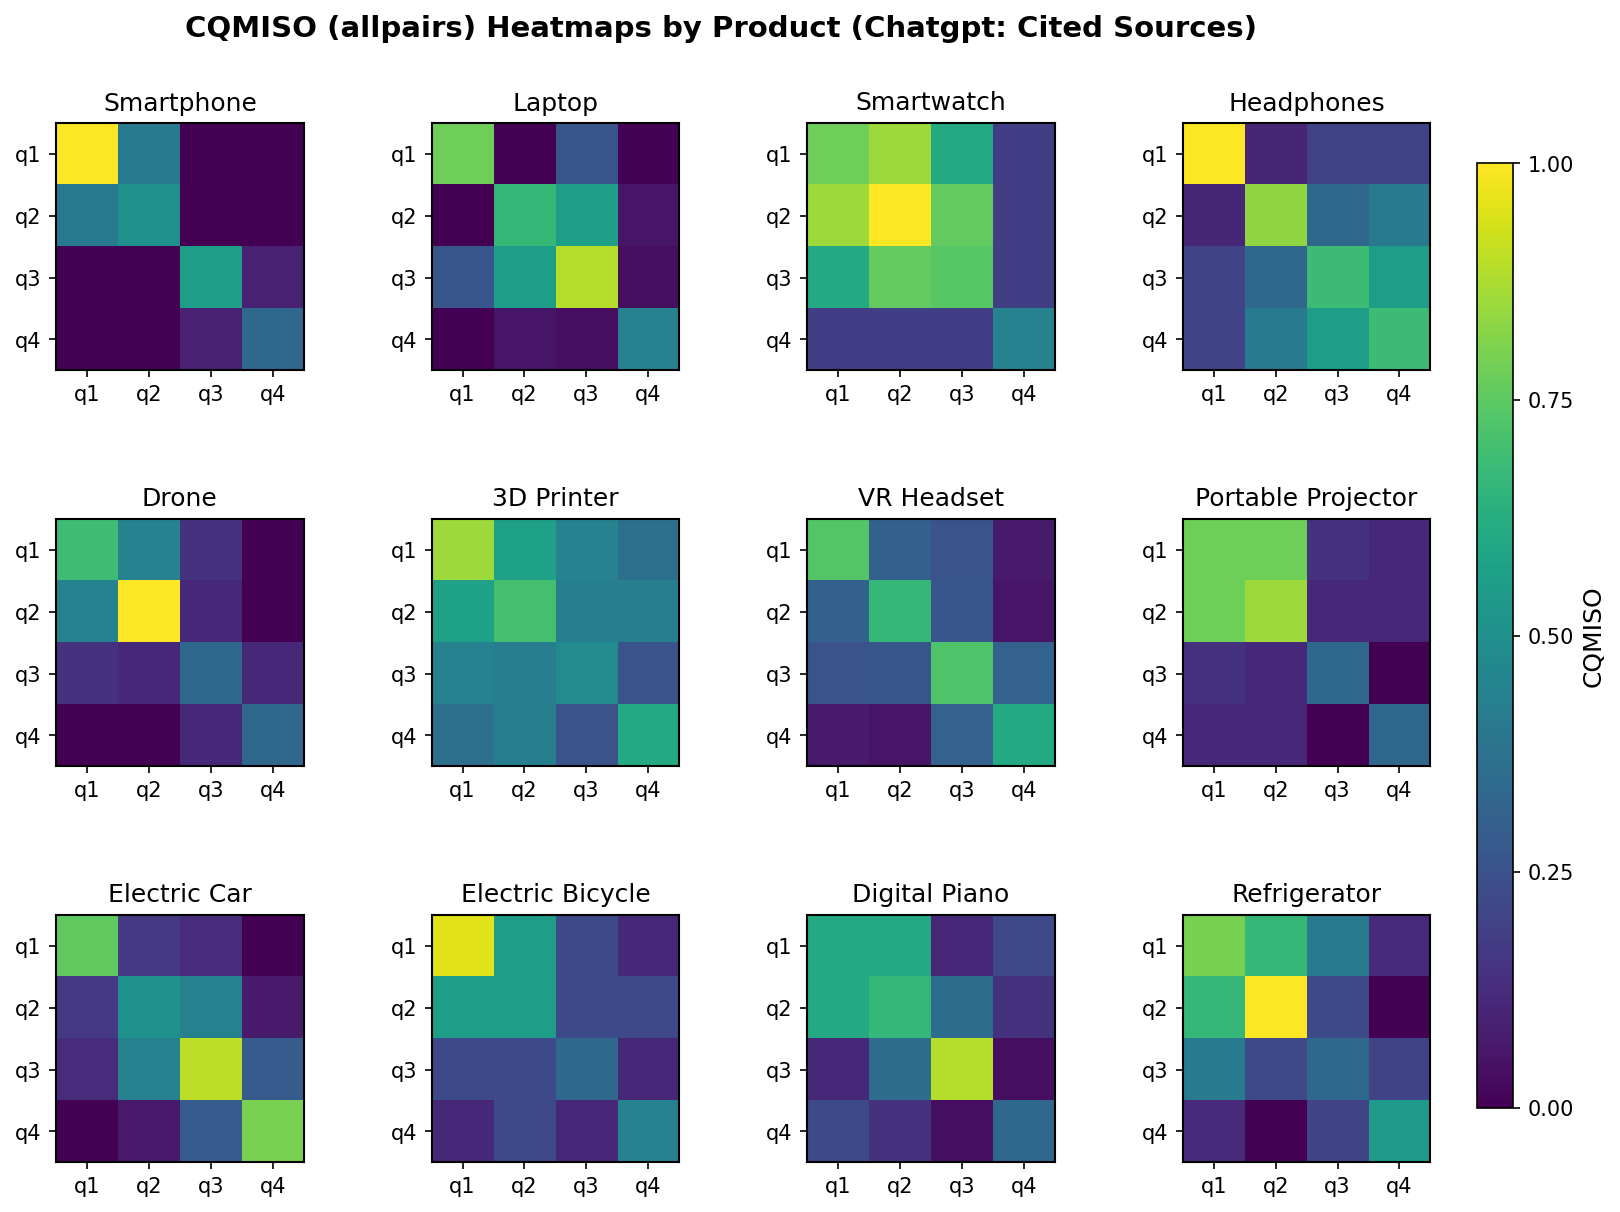

In [11]:
cqmiso_matrix_p_cs_a = calc_cqmiso_allpairs(chatgpt_df, source_col = "sources_cited", overlap_function = syntactic_overlap, filter_col = "product")
heatmaps(cqmiso_matrix_p_cs_a, chatgpt_df, filter_col = "product", title = "CQMISO (allpairs) Heatmaps by Product (Chatgpt: Cited Sources)", colorbar_label = "CQMISO")

<h4>CQMISO (allpairs) by Product (ChatGPT: Cited Sources)</h4> 

<p>This grid of heatmaps shows cross-query overlap of <em>cited</em> sources for each product. Warmer cells mean ChatGPT reused similar cited sources across different queries for that product, cooler cells mean little or no reuse. Overlap is uneven: some products show small clusters of warmer cells, while many pairs remain cool or zero.</p> 

<ul> 
    <li>Lower overlap reflects a narrow candidate set when only citations are counted. Strict attribution reduces source diversity that can be “matched” across queries.</li> 
    <li>Differences by product likely mirror market structure: broad, high-volume categories tend to have many competing pages (higher SERP competition and diversity), making consistent reuse harder; niche or fast-moving categories are sensitive to freshness and authority shifts, further lowering overlap.</li> 
    <li>LLM behavior matters: citation-mode encourages deduplication and constraint satisfaction (e.g., price/features), but extraction sensitivity can drop near-duplicates that lack explicit citations, keeping overlaps patchy.</li> 
</ul> 

<p>Overall, ChatGPT’s cited-source reuse across queries is limited and product-dependent, suggesting that explicit citation mode favors precision over cross-query consistency.</p>

Computing CQMIPO (filtered by product):   0%|          | 0/48 [00:00<?, ?query/s]

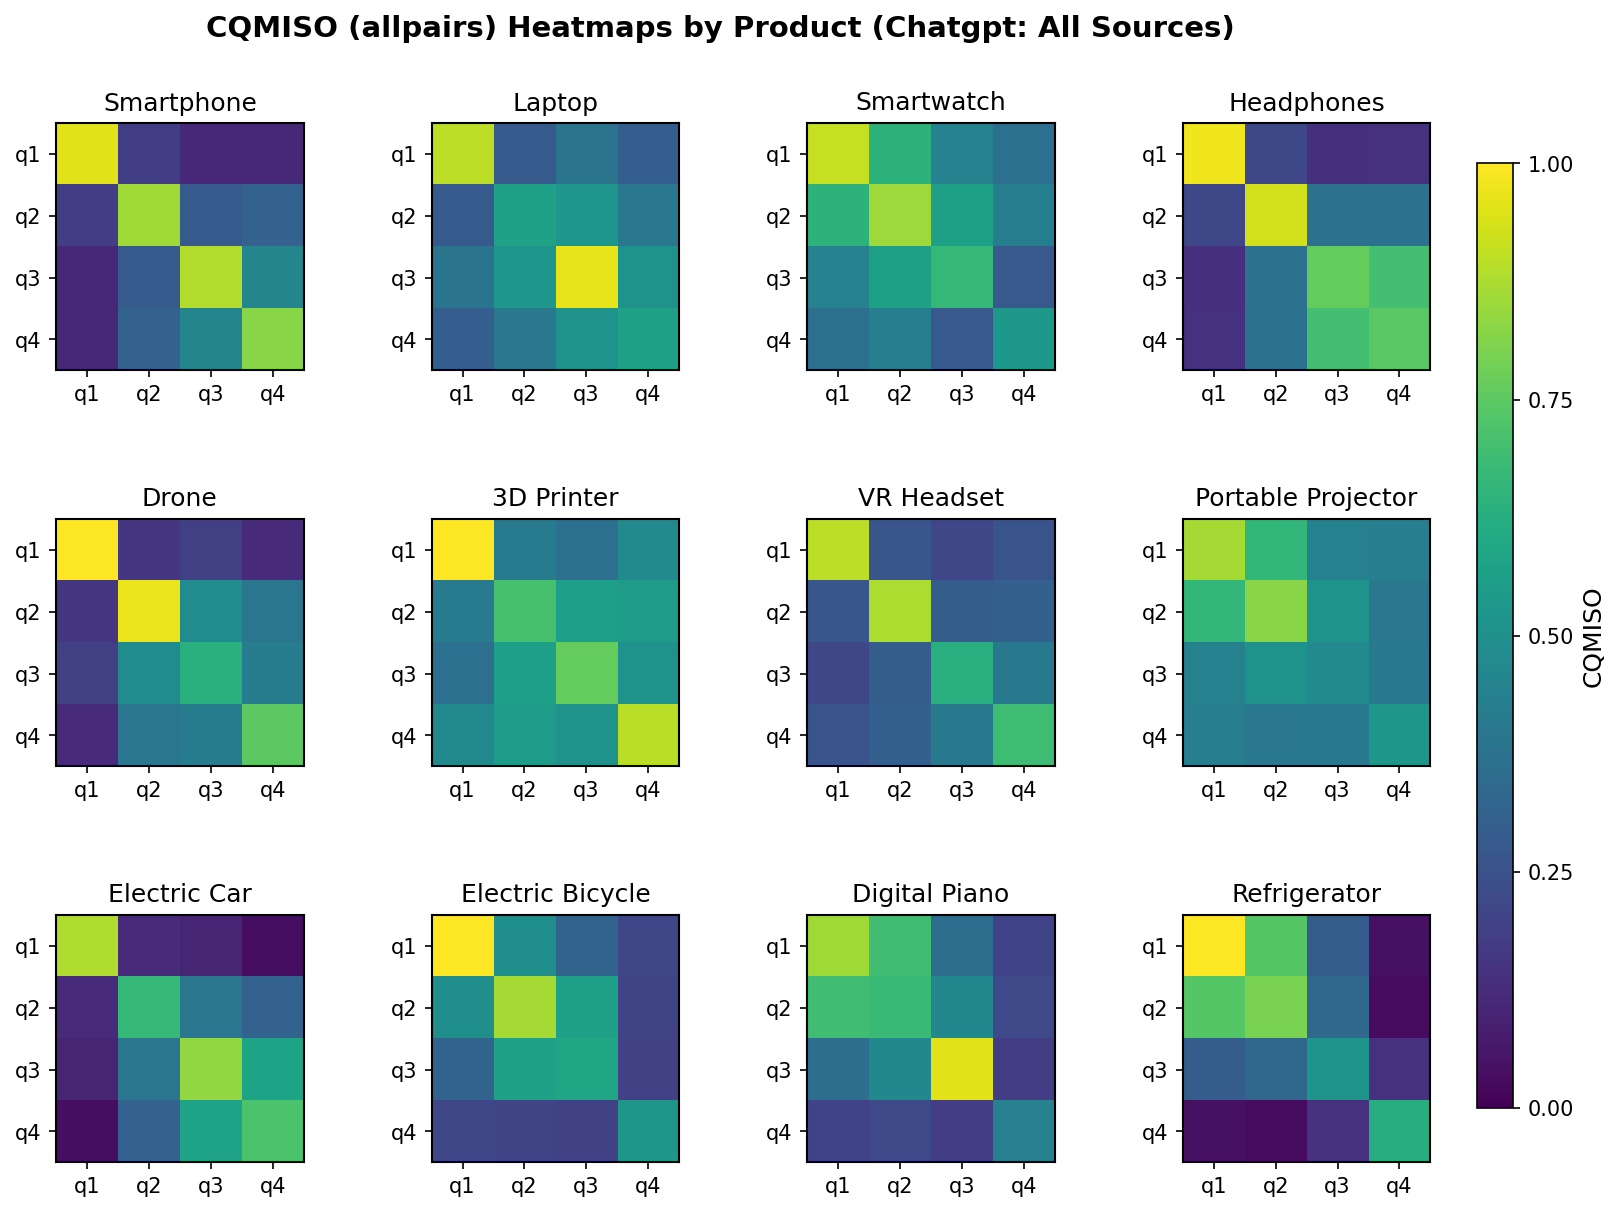

In [12]:
cqmiso_matrix_p_ca_a = calc_cqmiso_allpairs(chatgpt_df, source_col = "sources_all", overlap_function = syntactic_overlap, filter_col = "product")
heatmaps(cqmiso_matrix_p_ca_a, chatgpt_df, filter_col = "product", title = "CQMISO (allpairs) Heatmaps by Product (Chatgpt: All Sources)", colorbar_label = "CQMISO")

<h4>CQMISO (allpairs) by Product — ChatGPT: All Sources</h4> 

<p>These heatmaps repeat the analysis using <em>all</em> sources ChatGPT. Cells are generally warmer than in the cited-only view, indicating more cross-query reuse of source domains/text across the same product. Patterns still vary by product; some show clear clusters of overlap, others remain mixed.</p> 

<ul> 
    <li>Including additional sources per query expands the candidate pool, so intent-matched, authoritative, and well-covered domains recur across related queries, raising overlap.</li> 
    <li>For high-involvement products with rich editorial ecosystems, consistent authority (buyer guides, spec hubs) can dominate, while commodity spaces remain competitive, moderating overlap despite more sources.</li> 
    <li>LLM mechanisms—source coverage, paraphrase aggregation, and internal deduplication—promote reuse across queries even without explicit citations, explaining the warmer matrices versus the cited-only case.</li> 
</ul> 

<p>In sum, ChatGPT’s overall sourcing shows stronger internal consistency than its cited subset, reflecting broader retrieval coverage and less restrictive attribution filtering.</p>

<h4>Cross-Query Mean Internal Source Overlap (Positional) – Definition &amp; Implementation</h4> <p> To capture rank-sensitive consistency in source usage across queries, we define a positional variant of the Cross-Query Mean Internal Source Overlap (CQMISO). Unlike the all-pairs version, which considers every possible source comparison between two queries, the positional form focuses on how semantically similar sources are at the same ranked positions. This emphasizes alignment in ordering rather than mere content overlap. </p> <p> Formally, for each query $ q $, let the ranked list of sources retrieved or cited by ChatGPT be $ S_{GPT_q} = [s_{q1}, s_{q2}, \dots, s_{qK}] $. To measure positional overlap between two distinct queries $ i $ and $ j $, we define: </p> <p> $$ CQMISO_{\text{pos}}[i, j] = \frac{1}{K} \sum_{k=1}^{K} O_{\text{semantic}}(s_{ik}, s_{jk}) $$ </p> <p> where $ O_{\text{semantic}}(s_{ik}, s_{jk}) $ denotes the semantic overlap between the sources occupying the same rank $ k $ in queries $ i $ and $ j $. The value of $ K = \min(|S_{GPT_i}|, |S_{GPT_j}|) $ ensures comparisons are only made where both queries have valid source positions. A higher positional CQMISO value indicates greater rank-level consistency in ChatGPT’s source usage across queries—suggesting that the model preserves sourcing patterns even as query contexts vary. </p>

In [13]:
def calc_cqmiso_positional(chatgpt_df, source_col, overlap_function, filter_col = None):
    
    n = len(chatgpt_df)
    cqmiso_matrix = np.full((n, n), 0, dtype = float)
    product_lists = chatgpt_df[source_col].tolist()
    
    # filter
    filter_values = chatgpt_df[filter_col].tolist() if filter_col else [None] * n
    
    for i in tqdm(range(n), desc=f"Computing CQMIPO (filtered by {filter_col})", unit="query"):
        for j in range(i, n):
            if filter_col and filter_values[i] != filter_values[j]:
                continue
            
            # Compare l1 with l1, l2 with l2, l3 with l3
            position_overlaps = []
            for k in range(min(len(product_lists[i]), len(product_lists[j]))):
                overlap = syntactic_overlap(product_lists[i][k], product_lists[j][k])
                position_overlaps.append(overlap)
            
            # Mean across positions
            cqmiso = np.mean(position_overlaps) if position_overlaps else np.nan
            cqmiso_matrix[i, j] = cqmiso
            cqmiso_matrix[j, i] = cqmiso
    
    return pd.DataFrame(cqmiso_matrix, index=chatgpt_df["query"], columns=chatgpt_df["query"])

Computing CQMIPO (filtered by product):   0%|          | 0/48 [00:00<?, ?query/s]

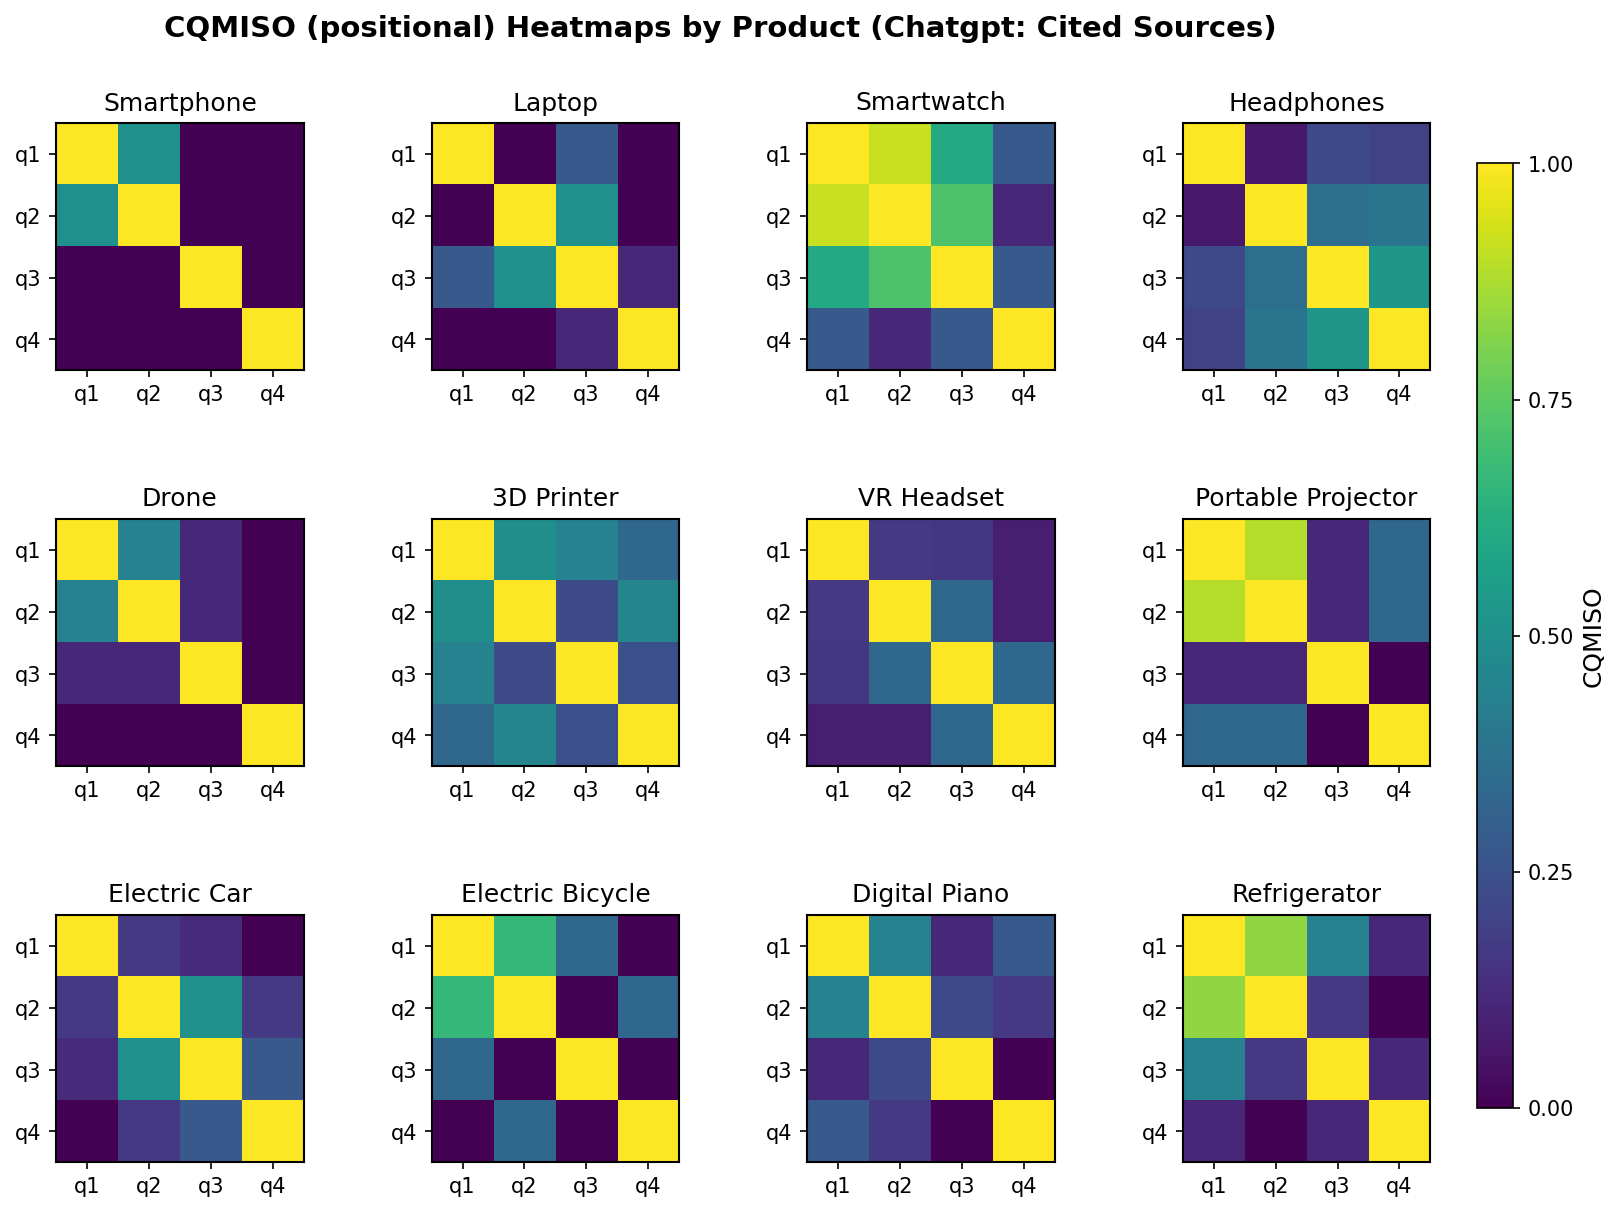

In [14]:
cqmiso_matrix_p_cs_p = calc_cqmiso_positional(chatgpt_df, source_col = "sources_cited", overlap_function = syntactic_overlap, filter_col = "product")
heatmaps(cqmiso_matrix_p_cs_p, chatgpt_df, filter_col = "product", title = "CQMISO (positional) Heatmaps by Product (Chatgpt: Cited Sources)", colorbar_label = "CQMISO")

<h4>CQMISO (positional) by Product — ChatGPT: Cited Sources</h4> 

<p>These heatmaps show rank-sensitive cross-query overlap of <em>cited</em> sources for each product. Each cell compares two queries (q1–q4) at matching positions (1st with 1st, 2nd with 2nd, etc.); warmer cells mean the same or semantically similar sources appear at the same ranks across queries for that product.</p> 

<ul> 
    <li>Positional overlap is uneven across products, indicating that citation-ranked sources shift with intent nuances even within the same product.</li> 
    <li>High SERP competition and diversity in broad categories can scramble rank order across queries, lowering positional consistency.</li> 
    <li>In citation mode, strict attribution plus LLM deduplication narrows the reusable set; extraction sensitivity to small title/URL changes further reduces rank-aligned matches.</li> 
</ul> 

<p>Overall, cited-source ordering is only moderately stable across related queries, suggesting precision-focused attribution outweighs cross-query rank consistency.</p>

Computing CQMIPO (filtered by product):   0%|          | 0/48 [00:00<?, ?query/s]

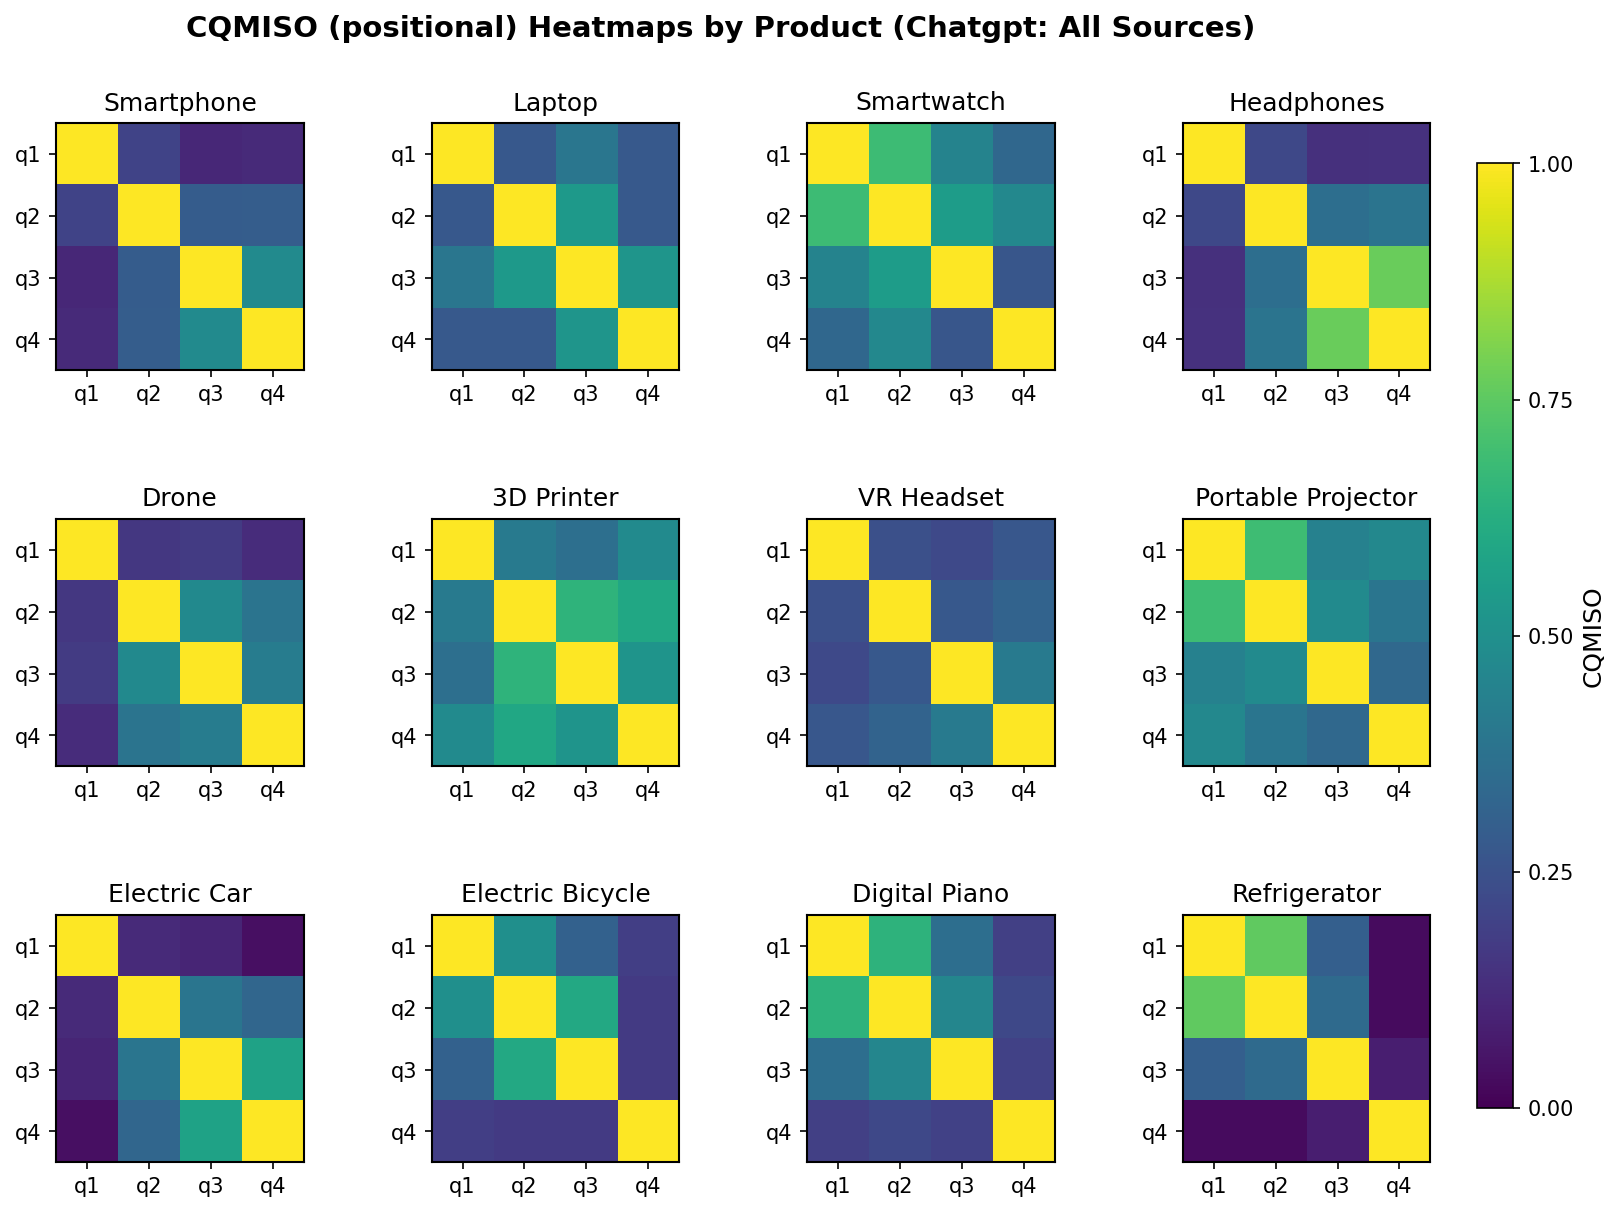

In [15]:
cqmiso_matrix_p_ca_p = calc_cqmiso_positional(chatgpt_df, source_col = "sources_all", overlap_function = syntactic_overlap, filter_col = "product")
heatmaps(cqmiso_matrix_p_ca_p, chatgpt_df, filter_col = "product", title = "CQMISO (positional) Heatmaps by Product (Chatgpt: All Sources)", colorbar_label = "CQMISO")

<h4>CQMISO (positional) by Product — ChatGPT: All Sources</h4> 

<p>These heatmaps repeat the rank-matched comparison using <em>all</em> sources (cited and uncited). Cells are generally warmer than in the cited-only view, indicating more consistent reuse of similarly ranked sources across queries within many products.</p> 

<ul> 
    <li>Including uncited material increases source coverage, so authoritative hubs and evergreen guides recur at similar ranks when intent matches, boosting positional overlap.</li> 
    <li>High-involvement markets with stable authority (spec databases, buying guides) tend to show clearer clusters, while commodity spaces still face SERP churn that limits alignment.</li> 
    <li>LLM behaviors—aggregation across multiple pages and internal deduplication—help preserve rank patterns when the candidate pool is larger than the cited subset.</li> 
</ul> 

<p>In sum, rank-level consistency across queries is stronger when all sources are considered, reflecting broader retrieval coverage and less restrictive attribution filtering.</p>